In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import inspect

In [2]:
%matplotlib inline

In [3]:
# 随机将变换尺度变成负数
def random_negate(degree):
    prob = np.random.uniform()
    if(prob < 0.5):
        degree = -degree
        
    return degree

# image aug

In [4]:
# 直方图均衡化
def equalize(image, *args):
    assert image.shape[2] == 3
    
    prob = np.random.uniform()
    if(prob < 0.5):
        # 50ms 更突出细节，（8，8）做一次均衡化
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        s1 = clahe.apply(image[:,:,0])
        s2 = clahe.apply(image[:,:,1])
        s3 = clahe.apply(image[:,:,2])
    else:
        # 30ms 全局去做
        s1 = cv2.equalizeHist(image[:,:,0])
        s2 = cv2.equalizeHist(image[:,:,1])
        s3 = cv2.equalizeHist(image[:,:,2])
    
    image = np.stack([s1, s2, s3], 2)
    return image

In [5]:
def cutout(image, pad_size, replace=0):


    # pad_size取决与gt_box的大小，而相应改变
    
    image_height = image.shape[0]
    image_width = image.shape[1]

    # 随机选择cutout的中心点
    cutout_center_height = np.random.randint(0, image_height)

    cutout_center_width = np.random.randint(0, image_width)

    x1 = np.clip(cutout_center_width - pad_size, 0, image_width)
    x2 = np.clip(cutout_center_width + pad_size, 0, image_width)
    y1 = np.clip(cutout_center_height - pad_size, 0, image_height)
    y2 = np.clip(cutout_center_height + pad_size, 0, image_height)
    
    x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)
    padding_shape = [y2-y1, x2-x1, 3]

    padding = np.ones(padding_shape) * replace
    image[y1:y2, x1:x2] = padding
    
    return image

In [6]:
# 水平平移
def translate_x(image, pixels, replace=0):
    # 平移尺度不能太大,主要是为了check box aug的方法
    while(abs(pixels) > image.shape[1]/10):
        pixels /= 2

    # 定义平移矩阵
    M = np.float32([[1, 0, -pixels], [0, 1, 0]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), borderValue = replace)
 
    # 返回转换后的图像
    return shifted

In [7]:
# 垂直平移
def translate_y(image, pixels, replace=0):
    # 平移尺度不能太大,主要是为了check box aug的方法
    while(abs(pixels) > image.shape[0]/10):
        pixels /= 2
        
    # 定义平移矩阵
    M = np.float32([[1, 0, 0], [0, 1, -pixels]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), borderValue = replace)
 
    # 返回转换后的图像
    return shifted

In [8]:
# bbox坐标偏移
def shift_bbox(bbox, image_height, image_width, pixels, shift_horizontal):
    
    min_y = bbox[1]
    min_x = bbox[0]
    max_y = bbox[3]
    max_x = bbox[2]
    
    if shift_horizontal:
        min_x = np.maximum(0, min_x - pixels)
        max_x = np.minimum(image_width, max_x - pixels)
    else:
        min_y = np.maximum(0, min_y - pixels)
        max_y = np.minimum(image_height, max_y - pixels)
    if( (min_x < max_x) and (min_y < max_y)):
        return [min_x, min_y, max_x, max_y]
    else:
        return []

In [9]:
# 图片和bbox同时平移
def translate_bbox(image, bboxes, pixels, replace, shift_horizontal):
    

    pixels = random_negate(pixels)

    # 图片平移
    if shift_horizontal:
        # 平移尺度不能太大
        while(abs(pixels) > image.shape[1]/10):
            pixels /= 2
        image = translate_x(image, pixels, replace)
    else:
        # 平移尺度不能太大
        while(abs(pixels) > image.shape[0]/10):
            pixels /= 2
        image = translate_y(image, pixels, replace)
    
    #bbox坐标平移
    image_height = image.shape[0]
    image_width = image.shape[1]
    trans_bboxes = []
    for bbox in bboxes:
        trans_bbox = shift_bbox(bbox, image_height, image_width, pixels, shift_horizontal)
        # 过滤掉面积为0的框
        if(trans_bbox != []):
            trans_bboxes.append(trans_bbox)
    
    return image, trans_bboxes

In [10]:
# 旋转
def rotate(image, degrees, replace, scale=1.0):

    degrees = random_negate(degrees)
        
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, degrees, scale)
    rotated = cv2.warpAffine(image, M, (w, h), borderValue = replace)
 
    # 返回旋转后的图像
    return rotated

In [11]:
# 旋转图片和bboxes
def rotate_with_bboxes(image, bboxes, degrees, replace):
    image = rotate(image, degrees, replace)
    
    # TODO: 旋转bboxes
#     image_height = image.shape[0]
#     image_width = image.shape[1]
#     trans_bboxes = []
#     for bbox in bboxes:
#         trans_bbox = rotate_bbox(bbox, image_height, image_width, degrees)
#         # 过滤掉面积为0的框
#         if(trans_bbox != []):
#             trans_bboxes.append(trans_bbox)
#     return image, trans_bboxes
    return image, bboxes

In [12]:
# 水平剪切
def shear_x(image, level, replace):
    (h, w) = image.shape[:2]
    M = np.float32([[1, level, 0],
                [0, 1, 0]])
    sheared = cv2.warpAffine(image, M, (w, h), borderValue = replace)
    
    return sheared

In [13]:
# 垂直剪切
def shear_y(image, level, replace):
    (h, w) = image.shape[:2]
    M = np.float32([[1, 0, 0],
                [level, 1, 0]])
    sheared = cv2.warpAffine(image, M, (w, h), borderValue = replace)
    
    return sheared

In [14]:
# shear后的bbox偏移
def shear_bbox(bbox, level, shear_horizontal):
    min_y = bbox[1]
    min_x = bbox[0]
    max_y = bbox[3]
    max_x = bbox[2]
    
    coordinates = np.float32([[min_y, min_x], [min_y, max_x], [max_y, min_x], [max_y, max_x]])
    
    if shear_horizontal:
        translation_matrix = np.float32(
            [[1, 0], [level, 1]])
    else:
        translation_matrix = np.float32(
            [[1, level], [0, 1]])
    new_coords = np.dot(translation_matrix, coordinates.T)
    
    min_y = new_coords[0, :].min()
    min_x = new_coords[1, :].min()
    max_y = new_coords[0, :].max()
    max_x = new_coords[1, :].max()
    
    if( (min_x < max_x) and (min_y < max_y)):
        return [min_x, min_y, max_x, max_y]
    else:
        return []

In [15]:
def shear_with_bboxes(image, bboxes, level, replace, shear_horizontal):
    
    level = random_negate(level)
    
    if shear_horizontal:
        image = shear_x(image, level, replace)
    else:
        image = shear_y(image, level, replace)
        
    sheared_bboxes = []
    for bbox in bboxes:
        sheared_bbox = shear_bbox(bbox, level, shear_horizontal)
        # 过滤掉面积为0的框
        if(sheared_bbox != []):
            sheared_bboxes.append(sheared_bbox)
    
    return image, sheared_bboxes

In [16]:
# 水平翻转
def flip_x(image, *args):
    
    flipped = cv2.flip(image, 1)#参数为0时纵向翻转，为-1时横向纵向同时翻转
    
    return flipped

In [17]:
# 水平翻转后bbox坐标翻转
def flip_x_bbox(image, bboxes):
    (h, w) = image.shape[:2]
    fliped_bboxes=[]
    for bbox in bboxes:
        min_y = bbox[1]
        min_x = w - bbox[2]
        max_y = bbox[3]
        max_x = w - bbox[0]
        fliped_bboxes.append([min_x, min_y, max_x, max_y])
        
    return fliped_bboxes

In [18]:
def filp_with_bboxes(image, bboxes, *args):
    
    image = flip_x(image)
    bboxes = flip_x_bbox(image, bboxes)
    
    return image, bboxes
    

# mutil boxes aug

In [19]:
def apply_multi_bbox_augmentation(image, bboxes, prob, aug_func, *args):
    num_bboxes = len(bboxes)
    # 每个bboxes，以prob概率执行aug_func
    count = 0
    if( num_bboxes > 0):
        for bbox in bboxes:
            apply_policy_prob = np.random.uniform()
            if(apply_policy_prob < prob):
                image = apply_bbox_augmentation(image, bbox, aug_func, *args)
                count += 1
    print("执行aug:{}次".format(count))
    return image, bboxes

In [20]:
def apply_bbox_augmentation(image, bbox, aug_func, *args):
    
    #image： h, w, c
    #box:(x1, y1, x2, y2)
    
    image_height = image.shape[0]
    image_width = image.shape[1]
    min_y = bbox[1]
    min_x = bbox[0]
    max_y = bbox[3]
    max_x = bbox[2]

    # Clip to be sure the max values do not fall out of range.
    max_y = np.minimum(max_y, image_height - 1)
    max_x = np.minimum(max_x, image_width - 1)

    # Get the sub-tensor that is the image within the bounding box region.
    bbox_content = image[min_y:max_y + 1, min_x:max_x + 1, :]

    # Apply the augmentation function to the bbox portion of the image.
    augmented_bbox_content = aug_func(bbox_content, *args)

    # Replace the old bbox content with the new augmented content.
    image[min_y:max_y+1, min_x:max_x+1] = augmented_bbox_content
    
    return image

In [21]:
def cutout_only_bboxes(image, bboxes, prob, pad_size, replace):

    return apply_multi_bbox_augmentation(image, bboxes, prob, cutout, pad_size, replace)

In [22]:
def translate_x_only_bboxes(image, bboxes, prob, pixels, replace):
    
    return apply_multi_bbox_augmentation(image, bboxes, prob, translate_x, pixels, replace)

In [23]:
def translate_y_only_bboxes(image, bboxes, prob, pixels, replace):
    
    return apply_multi_bbox_augmentation(image, bboxes, prob, translate_y, pixels, replace)

In [24]:
def equalize_only_bboxes(image, bboxes, prob, *args):
    
    return apply_multi_bbox_augmentation(image, bboxes, prob, equalize)

In [25]:
def rotate_only_bboxes(image, bboxes, prob, degrees, replace):
    
    return apply_multi_bbox_augmentation(image, bboxes, prob, rotate, degrees, replace)

In [26]:
# 所有的bboxes都会朝着一个方向shear
def shear_x_only_bboxes(image, bboxes, prob, level, replace):
    
    return apply_multi_bbox_augmentation(image, bboxes, prob, shear_x, level, replace)

In [27]:
def shear_y_only_bboxes(image, bboxes, prob, level, replace):
    
    return apply_multi_bbox_augmentation(image, bboxes, prob, shear_y, level, replace)

In [28]:
def flip_only_bboxes(image, bboxes, prob, level, replace):
    
    return apply_multi_bbox_augmentation(image, bboxes, prob, flip_x, level, replace)

# 函数入口

In [29]:
def bbox_wrapper(func):
    """Adds a bboxes function argument to func and returns unchanged bboxes."""

    def wrapper(images, bboxes, *args, **kwargs):
        return (func(images, *args, **kwargs), bboxes)

    return wrapper

In [30]:
def _parse_policy_info(name, prob, level, replace_value, augmentation_hparams):
    func = NAME_TO_FUNC[name]
    args = (float(level),)
    
    # 如果fun中含有prob参数，说明这是对所有box进行aug，需要传入prob参数
    if 'prob' in inspect.getargspec(func)[0]:
        args = tuple([prob] + list(args))
        
    if 'replace' in inspect.getargspec(func)[0]:
        # Make sure replace is the final argument
        assert 'replace' == inspect.getargspec(func)[0][-1]
        args = tuple(list(args) + [replace_value])
        
    if 'bboxes' not in inspect.getargspec(func)[0]:
        func = bbox_wrapper(func)
    
    return (func, prob, args)

In [31]:
def distort_image_with_autoaugment(image, bboxes, augmentation_name, aug_config):
    
    replace_value = [128, 128, 128]
    
    if(len(bboxes) == 0):
        return image, bboxes
    
    image = np.array(image)
    
    available_policies = {'test': policy_vtest, 'v1': policy_v1}
    if augmentation_name not in available_policies:
        raise ValueError('Invalid augmentation_name: {}'.format(augmentation_name))
        
    policies = available_policies[augmentation_name]()
    # 用来保存策略组函数final_policy
    my_policies = []
    for policy in policies:
        # 存放个子策略参数(func, prob, args)
        my_policy = []
        for policy_info in policy:
            policy_info = list(policy_info) + [replace_value, aug_config]
            my_policy.append(_parse_policy_info(*policy_info))
            
        # 以prob概率执行该prolicy中的每个func
        def make_final_policy(my_policy_):
            def final_policy(image_, bboxes_):
                for func, prob, args in my_policy_:
                    print(func, prob, args)
                    apply_policy_prob = np.random.uniform()
                    # 如果是对boxes进行aug，则直接执行func
                    if('prob' in inspect.getargspec(func)[0]):
                        apply_policy_prob = 0
                    if(apply_policy_prob < prob):
                        image_, bboxes_ = func(image, bboxes, *args)
                return image_, bboxes_
            return final_policy

        my_policies.append(make_final_policy(my_policy))
    
    # random select policy
    policy_to_select = np.random.randint(0, len(my_policies))
    for (i, policy) in enumerate(my_policies):
        if i == policy_to_select:
            augmented_images, augmented_bboxes = policy(image, bboxes)
            
    return augmented_images, augmented_bboxes


# config

In [32]:
def policy_vtest():
    # for debug
    policy = [
        [("ShearY_Only_BBoxes", 0, 1), ("TranslateY_Only_BBoxes", 1, 100)],
    ]
    return policy

def policy_v1():
    # 每个策略为：(operation, probability, magnitude)，magnitude推荐值在下面
    # 每张图片会选择一行策略，然后依次执行
    policy = [
        [('TranslateX_BBox', 0.6, 100), ('Equalize', 0.8, 10)],
        [('TranslateY_Only_BBoxes', 0.5, 10), ('Cutout_Only_BBoxes', 0.6, 5)],
        [('ShearX_BBox', 0.4, 0.06)],
        [('ShearY_BBox', 1.0, 0.06), ('TranslateY_Only_BBoxes', 0.6, 5)],
        [('Rotate_Only_BBoxes', 0.6, 10), ('Filp_Bboxes', 0.5, 1)],
        [('Flip_Only_BBoxes', 0.8, 1)],
    ]
    return policy

In [33]:
class aug_config:
    cutout_max_pad_fraction=0.75
    cutout_bbox_replace_with_mean=False
    cutout_const=100
    translate_const=250
    cutout_bbox_const=50
    translate_bbox_const=120
    

NAME_TO_FUNC = {
    # Color operations
    'Equalize': equalize,# 第三个参数没用，随便填
    
    # Geometric operations
    'Cutout': cutout,# 添加灰色mask的半径，取决于输入图片大小，推荐[0,60]
    'Filp_Bboxes':filp_with_bboxes,# 第三个参数没用，随便填
    
    'TranslateX_BBox': lambda image, bboxes, pixels, replace: translate_bbox(
        image, bboxes, pixels, replace, shift_horizontal=True),# 平移图片，pixels大于width的1/10时，会进行自动裁剪，直到满足
    'TranslateY_BBox': lambda image, bboxes, pixels, replace: translate_bbox(
        image, bboxes, pixels, replace, shift_horizontal=False),# 平移图片，pixels大于height的1/10时，会进行自动裁剪，直到满足
    'ShearX_BBox': lambda image, bboxes, level, replace: shear_with_bboxes(
        image, bboxes, level, replace, shear_horizontal=True),# 推荐值[0.06, 0.1]
    'ShearY_BBox': lambda image, bboxes, level, replace: shear_with_bboxes(
        image, bboxes, level, replace, shear_horizontal=False),# 推荐值[0.06, 0.1]
    'Rotate_BBox': rotate_with_bboxes,#TODO，先不要用

    # TODO: box aug的方向还没有全部随机
    # TODO: 应该根据每个box的尺度，自适应pixel相关的参数
    # Bounding box operations
    'Cutout_Only_BBoxes': cutout_only_bboxes,# 添加灰色mask的半径，取决于bbox大小，推荐5左右
    'Flip_Only_BBoxes': flip_only_bboxes,# 第三个参数没用，随便填
    'TranslateX_Only_BBoxes': translate_x_only_bboxes,# pixels大于bbox width的1/10时，会进行自动裁剪，直到满足
    'TranslateY_Only_BBoxes': translate_y_only_bboxes,# pixels大于bbox height的1/10时，会进行自动裁剪，直到满足，大于0则向上偏移
    'ShearX_Only_BBoxes': shear_x_only_bboxes,# 推荐值[0.06, 0.1]
    'ShearY_Only_BBoxes': shear_y_only_bboxes,# 推荐值[0.06, 0.1]
    'Equalize_Only_BBoxes': equalize_only_bboxes,# 第三个参数没用，随便填
    'Rotate_Only_BBoxes': rotate_only_bboxes,# 角度推荐取值范围[0,30]，行人数据集推荐10
    
}


# test

In [34]:
# read annotation
def read_sur_anno():
    from collections import defaultdict
    train_bbox_path = "/data/dataset/widerped2019/Annotations/train_bbox.txt" 
    security = defaultdict(list)
    with open(train_bbox_path) as file:
        for line in file:
            if(line.startswith("sur")):
                anno = line.strip().split(" ")
                filename = anno[0]
                anno.pop(0)
                results=[]
                if(len(anno) > 0):
                    for i in range(0, len(anno), 4):
                        x, y, w, h = anno[i:i+4]
                        x, y, w, h = int(x), int(y), int(w), int(h)
                        x1 = x 
                        x2 = x + w
                        y1 = y 
                        y2 = y + h
                        results.append([x1, y1, x2, y2])
                security[filename] = results
    return security

In [35]:
# draw gt
def draw_gt(img, annos):
    for anno in annos:
        cv2.rectangle(img, (int(anno[0]), int(anno[1])), (int(anno[2]), int(anno[3])), (0, 255, 0), 2)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead


<function flip_only_bboxes at 0x7fa160082c80> 0.8 (0.8, 1.0, [128, 128, 128])
执行aug:9次


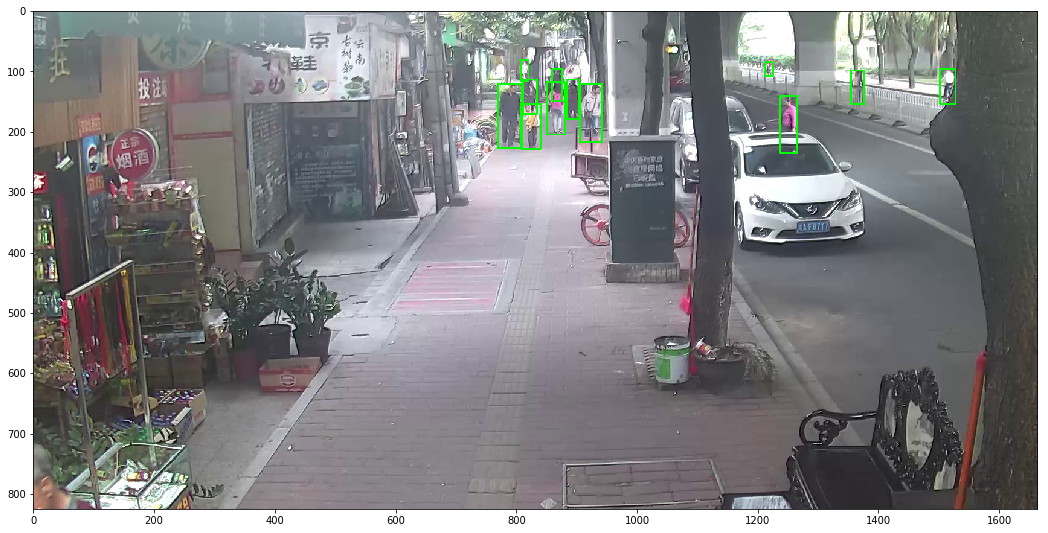

In [36]:
def main():
    img_name = "sur00216.jpg"
    image_root_path = "/data/dataset/widerped2019/sur_train/sur_train/"
    img_path = os.path.join(image_root_path,img_name)
    img = cv2.imread(img_path)
    surcity = read_sur_anno()
    bboxes = surcity[img_name]
    c = aug_config
    aug_img, aug_bboxes = distort_image_with_autoaugment(img, bboxes, "v1", c)
    draw_gt(aug_img, aug_bboxes)
    plt.figure(figsize=(18,18))
    aug_img=cv2.cvtColor(aug_img,cv2.COLOR_BGR2RGB)
    plt.imshow(aug_img)

main()

In [37]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
